Training Set Size: (941, 16)
Testing Set Size: (236, 16)
Applied SMOTE Oversampling. New Training Set Size: (1470, 16)
Applied Random UnderSampling. New Training Set Size: (1470, 16)
Model Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        52
           1       0.88      0.94      0.91        52
           2       0.97      0.97      0.97        36
           3       1.00      0.80      0.89         5
           4       1.00      1.00      1.00        12
           5       0.95      0.91      0.93        45
           6       1.00      0.97      0.99        34

    accuracy                           0.95       236
   macro avg       0.97      0.94      0.95       236
weighted avg       0.96      0.95      0.95       236



<Figure size 640x480 with 0 Axes>

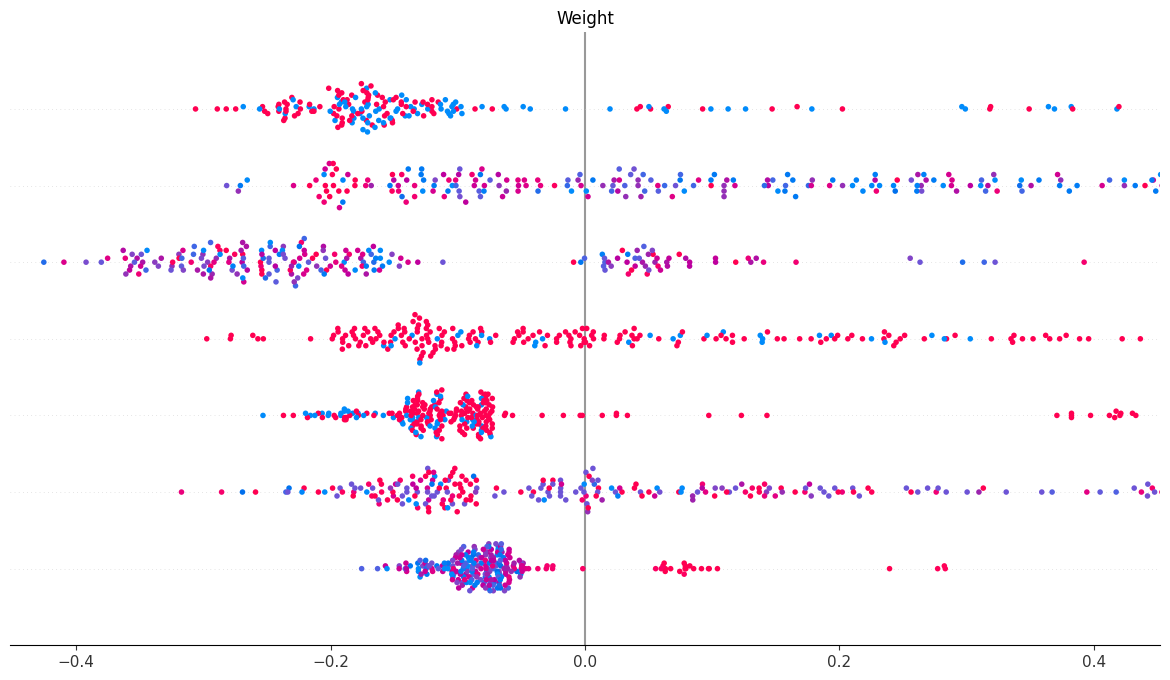

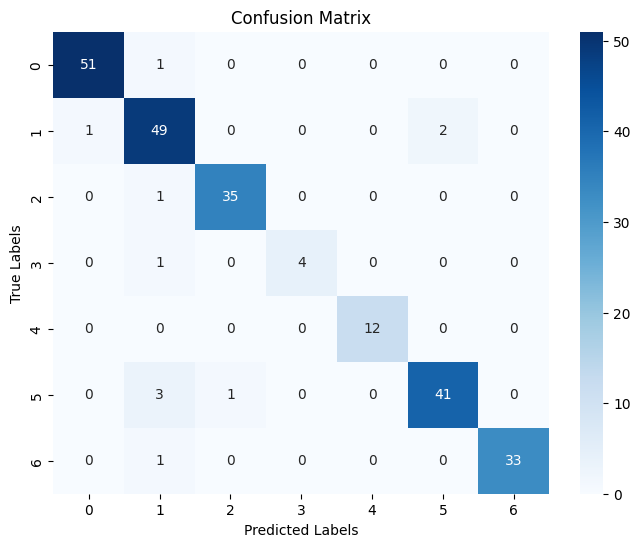

ROC-AUC Score For Random Forest: 0.9985
Label Encoding Mapping for NObeyesdad:
{'Insufficient_Weight': np.int64(0), 'Normal_Weight': np.int64(1), 'Obesity_Type_I': np.int64(2), 'Obesity_Type_II': np.int64(3), 'Obesity_Type_III': np.int64(4), 'Overweight_Level_I': np.int64(5), 'Overweight_Level_II': np.int64(6)}
Training Features: ['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS']
Total Features Used in Training: 16


'\'\n# Check class distribution\nclass_counts = df["NObeyesdad"].value_counts(normalize=True) * 100  # Get percentages\nprint("Class Distribution:\n", class_counts)\n\n# Plot class distribution\nplt.figure(figsize=(10, 5))\nsns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")\nplt.xticks(rotation=45)\nplt.xlabel("Obesity Level")\nplt.ylabel("Percentage of Samples")\nplt.title("Class Distribution of Obesity Levels")\nplt.show()\n\nplt.figure(figsize=(10,5))\nsns.boxplot(data=df)\nplt.xticks(rotation=90)\nplt.show()'

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
import shap


df = pd.read_csv(r"C:\Users\HP\Documents\GitHub\Coding-week-test\data\age_and_weight_cleaned.csv")





categorical_columns = ["Gender", "family_history_with_overweight", "NObeyesdad","FAVC","SMOKE","CAEC","SCC","CALC","MTRANS",]

##########spliting data###############
# Apply Label Encoding
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Save encoders if you need to inverse transform later

# Split into features (X) and target (y)
X = df.drop("NObeyesdad", axis=1)  # Features
y = df["NObeyesdad"]  # Target (Obesity Level)



# Split into 80% Training and 20% Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training Set Size:", X_train.shape)
print("Testing Set Size:", X_test.shape)


# ==== FLAGS FOR SAMPLING METHODS ====
USE_SMOTE = True           # Enable/Disable Oversampling
USE_UNDERSAMPLING = True  # Enable/Disable Undersampling
USE_CLASS_WEIGHTS = False  # Set this to True to use class weighting


# Apply Oversampling (SMOTE)
if USE_SMOTE:
    smote = SMOTE(sampling_strategy="auto", random_state=42)  # 60% oversampling
    X_train, y_train = smote.fit_resample(X_train, y_train)
    print("Applied SMOTE Oversampling. New Training Set Size:", X_train.shape)

# Apply Undersampling (RandomUnderSampler)
if USE_UNDERSAMPLING:
    undersample = RandomUnderSampler(sampling_strategy="auto", random_state=42)  # 80% of majority class
    X_train, y_train = undersample.fit_resample(X_train, y_train)
    print("Applied Random UnderSampling. New Training Set Size:", X_train.shape)

# Compute Class Weights (If Selected)
class_weight_dict = None
if USE_CLASS_WEIGHTS:
    class_weights = compute_class_weight(class_weight="balanced", 
                                         classes=np.unique(y_train), y=y_train)
    class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}
    print("Applied Class Weights:", class_weight_dict)


##################training#############

# Initialize Model with Selected Class Weights
model = RandomForestClassifier(n_estimators=100, random_state=42, 
                               class_weight=class_weight_dict if USE_CLASS_WEIGHTS else "balanced")


# Train Model
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)



#evaluation

# Check Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Detailed Performance Report
print("Classification Report:\n", classification_report(y_test, y_pred))

#explaination


explainer = shap.TreeExplainer(model)  # Use TreeExplainer for tree models
shap_values = explainer.shap_values(X_test)  # Ensure X_test matches training format

# Visualize Feature Importance
shap.summary_plot(shap_values, X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()



# Binarize the labels for multi-class ROC-AUC
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6])

# Compute ROC-AUC Score
roc_auc = roc_auc_score(y_test_binarized, model.predict_proba(X_test), multi_class="ovr")

print(f"ROC-AUC Score For Random Forest: {roc_auc:.4f}")

print("Label Encoding Mapping for NObeyesdad:")
print(dict(zip(label_encoders["NObeyesdad"].classes_, label_encoders["NObeyesdad"].transform(label_encoders["NObeyesdad"].classes_))))

import pickle
from sklearn.ensemble import RandomForestClassifier

# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)  # Assuming you have already split the data


print("Training Features:", list(X_train.columns))
print("Total Features Used in Training:", X_train.shape[1])

"""
# Save the trained model to a file
with open("model.pkl", "wb") as file:
    pickle.dump(model, file)

print("Model saved successfully!")

import shap
import pickle

# Train SHAP explainer after training your model
explainer = shap.TreeExplainer(model)

# Save SHAP explainer to a file
with open("shap_explainer.pkl", "wb") as file:
    pickle.dump(explainer, file)

print("SHAP explainer saved successfully as shap_explainer.pkl!")

le = LabelEncoder()
df["NObeyesdad"] = le.fit_transform(df["NObeyesdad"])  # Encoding obesity levels

import pickle

# Save LabelEncoder
with open("label_encoder.pkl", "wb") as file:
    pickle.dump(le, file)

"""

"""
######## to delete ##########
# Define outlier removal conditions (example for Weight)
lower_bound = 40  # Minimum valid weight
upper_bound = 105  # Maximum valid weight
l_b=10
u_b=26

# Filter data (without modifying the original file)
df_filtered = df[(df["Weight"] >= lower_bound) & (df["Weight"] <= upper_bound)]

#df_filtered = df[(df["Age"] >= l_b) & (df["Age"] <= u_b)]

######## to save ##########
df_filtered.to_csv("age_and_weight_cleaned.csv", index=False)
"""
"""
######## to plot ##########
# Set figure size
plt.figure(figsize=(12, 6))

# Boxplot for Age vs. Obesity Level
sns.boxplot(x=df["NObeyesdad"], y=df["Age"], palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Age Distribution Across Obesity Levels")
plt.show()


sns.boxplot(x=df["NObeyesdad"], y=df["Weight"], palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Age Distribution Across Obesity Levels")
plt.show()

# Plot the boxplot of the filtered dataset
plt.figure(figsize=(10, 5))
sns.boxplot(data=df)
#sns.boxplot(data=df_filtered)
plt.xticks(rotation=90)
plt.title("Boxplot After Removing Outliers (Without Saving)")
plt.show()

# Boxplot for Weight vs. Obesity Level
plt.figure(figsize=(12, 6))
sns.boxplot(x=df["NObeyesdad"], y=df["Weight"], palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Weight Distribution Across Obesity Levels")
plt.show()

# Boxplot for Physical Activity Frequency (FAF) vs. Obesity Level
plt.figure(figsize=(12, 6))
sns.boxplot(x=df["NObeyesdad"], y=df["FAF"], palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Physical Activity (FAF) Across Obesity Levels")
plt.show()
"""

"""

'''

# Convert all categorical columns to numeric
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category').cat.codes


# Convert categorical target variable to numeric for correlation analysis
df["Obesity_Level_Num"] = df["NObeyesdad"].astype("category").cat.codes

# Compute correlation matrix
corr_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()




print(df['NObeyesdad'].value_counts(normalize=True) * 100)

'''
"""
'''
# Convert categorical features to numeric (if any)
df_encoded = pd.get_dummies(df, drop_first=True)

# Compute correlation matrix
correlation_matrix = df_encoded.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()
'''
''''
# Check class distribution
class_counts = df["NObeyesdad"].value_counts(normalize=True) * 100  # Get percentages
print("Class Distribution:\n", class_counts)

# Plot class distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("Obesity Level")
plt.ylabel("Percentage of Samples")
plt.title("Class Distribution of Obesity Levels")
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.show()'''

In [9]:
df = pd.read_csv(r"C:\Users\HP\Documents\GitHub\Coding-week-test\data\ObesityDataSet.csv")

# Define outlier removal conditions
lower_weight, upper_weight = 40, 105  # Valid Weight Range
lower_age, upper_age = 10, 26  # Valid Age Range

# Identify Outliers (Values Outside the Defined Ranges)
outliers = df[(df["Weight"] < lower_weight) | (df["Weight"] > upper_weight) | 
              (df["Age"] < lower_age) | (df["Age"] > upper_age)]

# Save Outliers Before Removing
outliers.to_csv("test data.csv", index=False)




print(f"✅ Outliers saved in 'removed_outliers.csv'")


✅ Outliers saved in 'removed_outliers.csv'


In [5]:
df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,21.000000,1.620000,64.000000,1,0,2.0,3.0,2,0,2.000000,0,0.000000,1.000000,3,3,1
1,0,21.000000,1.520000,56.000000,1,0,3.0,3.0,2,1,3.000000,1,3.000000,0.000000,2,3,1
2,1,23.000000,1.800000,77.000000,1,0,2.0,3.0,2,0,2.000000,0,2.000000,1.000000,1,3,1
3,1,22.000000,1.780000,89.800000,0,0,2.0,1.0,2,0,2.000000,0,0.000000,0.000000,2,3,6
4,0,23.000000,1.500000,55.000000,1,1,3.0,3.0,2,0,2.000000,0,1.000000,0.000000,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,0,25.470652,1.680218,104.807284,1,1,3.0,3.0,2,0,1.423073,0,0.197993,0.763359,2,3,4
1173,0,25.289428,1.686033,104.772164,1,1,3.0,3.0,2,0,1.299194,0,0.234303,0.946888,2,3,4
1174,0,25.977310,1.617817,104.950776,1,1,3.0,3.0,2,0,1.716590,0,0.001272,0.545993,2,3,4
1175,0,25.955014,1.626449,104.879602,1,1,3.0,3.0,2,0,2.094901,0,0.070890,0.599441,2,3,4


In [6]:
df.shape

(1177, 17)

In [7]:
df.describe()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
count,1177.000000,1177.000000,1177.000000,1177.000000,1177.000000,1177.000000,1177.000000,1177.000000,1177.000000,1177.000000,1177.000000,1177.000000,1177.000000,1177.000000,1177.000000,1177.000000,1177.000000
mean,0.492778,20.882142,1.681322,71.497324,0.711980,0.831776,2.340176,2.641494,1.785047,0.017842,1.948435,0.073917,1.080704,0.792490,2.361088,2.771453,2.598980
std,0.500160,2.559341,0.089222,17.793489,0.453033,0.374224,0.549652,0.893012,0.568906,0.132433,0.623909,0.261747,0.917299,0.653047,0.552928,0.876527,2.234303
min,0.000000,14.000000,1.450000,40.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,18.909439,1.614484,56.000000,0.000000,1.000000,2.000000,2.278652,2.000000,0.000000,1.438018,0.000000,0.139159,0.003229,2.000000,3.000000,1.000000
50%,0.000000,21.000000,1.681314,70.000000,1.000000,1.000000,2.081238,3.000000,2.000000,0.000000,2.000000,0.000000,1.000000,0.929356,2.000000,3.000000,2.000000
75%,1.000000,22.980957,1.744020,84.497980,1.000000,1.000000,3.000000,3.000000,2.000000,0.000000,2.279214,0.000000,2.000000,1.064700,3.000000,3.000000,5.000000
max,1.000000,26.000000,1.930000,105.000000,1.000000,1.000000,3.000000,4.000000,3.000000,1.000000,3.000000,1.000000,3.000000,2.000000,3.000000,4.000000,6.000000
